In [1]:
from datasets import load_dataset, concatenate_datasets, load_from_disk
code_data = load_dataset("sahil2801/CodeAlpaca-20k")["train"]
print(len(code_data))

20022


In [2]:
print(len(code_data["instruction"]))

20022


In [2]:
from FlagEmbedding import FlagModel
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="",
                  use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

----------using 8*GPUs----------


In [ ]:
from tqdm import tqdm
embeddings = model.encode(code_data["instruction"])

In [ ]:
import numpy as np
sampled_indices = np.random.choice(len(embeddings), 100, replace=False)
sampled_embeddings = embeddings[sampled_indices]

In [11]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

In [12]:
tsne_model = TSNE(n_components=2, random_state=0, metric='cosine')
tsne_results = tsne_model.fit_transform(sampled_embeddings)

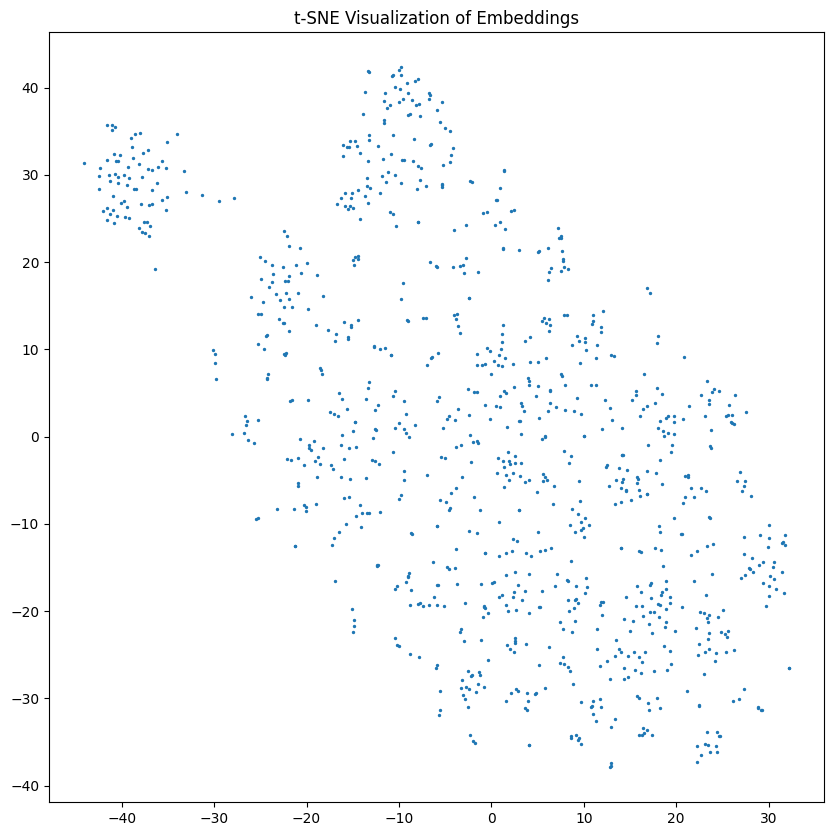

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=2)
plt.title('t-SNE Visualization of Embeddings')
plt.show()

In [15]:
from sklearn.cluster import KMeans

In [16]:
# 假设 embeddings 是你的嵌入数据
k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)

In [21]:
print(kmeans)

KMeans(n_clusters=10, random_state=0)


In [17]:
predicted_labels = kmeans.labels_

In [ ]:
print(predicted_labels)

In [18]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(embeddings, predicted_labels)
print("Silhouette Coefficient: ", silhouette_avg)

Silhouette Coefficient:  0.036262311902881754


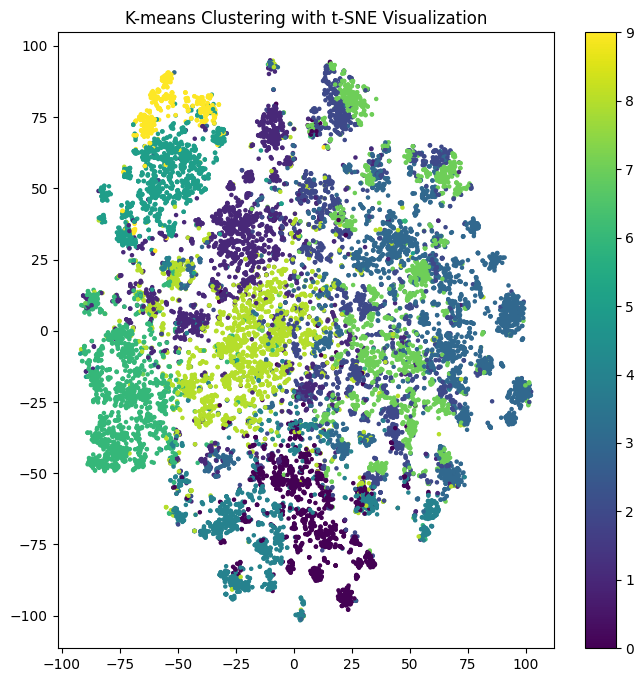

In [23]:
# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(embeddings)

# 可视化
plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=predicted_labels, cmap='viridis', s=5)
plt.title("K-means Clustering with t-SNE Visualization")
plt.colorbar()
plt.show()

In [ ]:
cluster_centers = kmeans.cluster_centers_
print("Cluster centers:\n", cluster_centers)

# Financial

In [5]:
data1 = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
print(len(data1["input"]))

76772


In [3]:
def concat_columns(example: dict):
    # 将 instruction 和 input 列的值拼接起来，用空格分隔
    if "input" in example.keys() and example["input"] is not None:
        example['text'] = example['instruction'] + ' ' + example['input']
    else:
        example["text"] = example["instruction"]
    return example

In [7]:
from datasets import concatenate_datasets
data_concated = concatenate_datasets([data,data1]).map(concat_columns)

In [6]:
print(len(data_concated["text"]))

96794


In [20]:
from tqdm import tqdm
concated_embeddings = model.encode(data_concated["text"])

Inference Embeddings: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


In [ ]:
import numpy as np
# sampled_indices = np.random.choice(len(embeddings), 1000, replace=False)
# sampled_embeddings = embeddings[sampled_indices]
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
tsne_model = TSNE(n_components=2, random_state=0, metric='cosine')
tsne_results = tsne_model.fit_transform(concated_embeddings)
import matplotlib.pyplot as plt

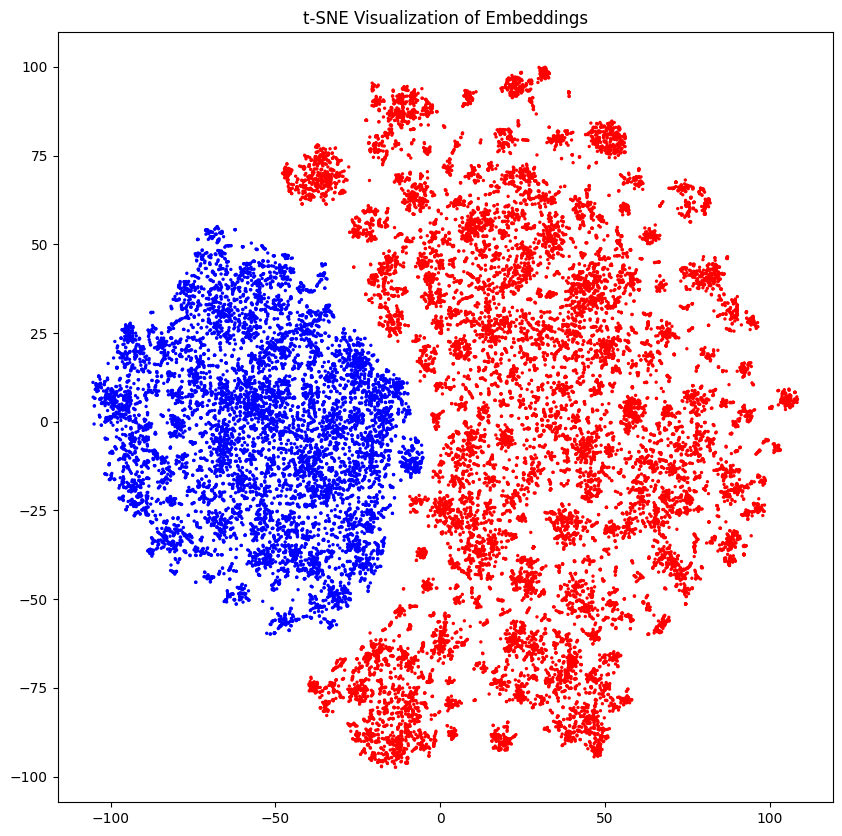

In [29]:
colors = ['red' if i < 20022 else 'blue' for i in range(len(tsne_results))]
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, s=2)
plt.title('t-SNE Visualization of Embeddings')
plt.show()

# 构造多 domain 公共数据集

In [4]:
fin_data = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
med_data = load_dataset("medalpaca/medical_meadow_medical_flashcards")["train"]
general_data = load_dataset("tatsu-lab/alpaca")["train"]
math_data = load_dataset("TIGER-Lab/MathInstruct")["train"]

for name, d in zip(["code","fin","med","gen","math"],[code_data,fin_data,med_data,general_data,math_data]):
    print(f"{name} len {len(d)}")

data_concated = concatenate_datasets([code_data,fin_data,med_data,general_data,math_data])

code len 20022
fin len 76772
med len 33955
gen len 52002
math len 262039


# 构造 base 数据集

In [5]:
import numpy as np
import random

In [6]:
random.seed(10)
sampled_indices = random.sample(range(len(code_data)), 100)
sampled_data = code_data.select(sampled_indices)

## 构造 base 数据集

In [24]:
sampled_data.save_to_disk("/mnt/bn/data-tns-live-llm/leon/datasets/base.parquet")

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

## 从 concated dataset 中去掉 base 数据

In [7]:
sampled_set = set(sampled_indices)
base_set = set(range(len(data_concated)))

# 计算差集，即在 idx_set 中但不在 sampled_set 中的元素
remaining_idx = list(base_set - sampled_set)
print(len(remaining_idx))

444690


In [8]:
data_concated = data_concated.select(remaining_idx)

### 从 concated dataset 中随机采样构造随机采样补充数据集

In [26]:
print(len(data_concated))

444690


In [32]:
random_indices = random.sample(range(len(data_concated)), k=5000)
random_data = data_concated.select(random_indices)
print(len(random_data))

5000
5000


In [33]:
base_datasets = concatenate_datasets([sampled_data, random_data])

In [35]:
base_datasets.save_to_disk("/mnt/bn/data-tns-live-llm/leon/datasets/random.parquet")

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

In [34]:
print(len(base_datasets))

5100


## 根据 sample data聚类的 prototype 从混合数据集中选择相关数据构造 pos 数据集和 neg 数据集

In [9]:
sampled_data = sampled_data.map(concat_columns)
sampled_embeddings = model.encode(sampled_data["text"])

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [10]:
from sklearn.cluster import KMeans
# 假设 embeddings 是你的嵌入数据
k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(sampled_embeddings)
print(kmeans)

KMeans(n_clusters=10, random_state=0)


In [11]:
from tqdm import tqdm
data_concated = data_concated.map(concat_columns)

Map:   0%|          | 0/444690 [00:00<?, ? examples/s]

In [12]:
concated_embeddings = model.encode(data_concated["text"])

Inference Embeddings: 100%|██████████| 218/218 [02:50<00:00,  1.28it/s]


In [13]:
import torch
clusters = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
concated_embeddings = torch.tensor(concated_embeddings, dtype=torch.float32)
print(type(clusters))

<class 'torch.Tensor'>


# 密集检索

In [14]:
import torch
import heapq
similarity_scores = clusters @ concated_embeddings.T
print(similarity_scores.shape)

torch.Size([10, 444690])


In [15]:
top_idxs = []
bot_idxs = []
for i in range(similarity_scores.shape[0]):
    tmp = similarity_scores[i]
    top_idxs.append(heapq.nlargest(500, range(len(tmp)), key=tmp.__getitem__))
    bot_idxs.append(heapq.nsmallest(500, range(len(tmp)), key=tmp.__getitem__))

## 构造pos数据集和neg数据集

In [16]:
pos_datasets = []
neg_datasets = []
for i in range(len(top_idxs)):
    pos_datasets.append(data_concated.select(top_idxs[i]))
    neg_datasets.append(data_concated.select(bot_idxs[i]))
pos_datasets = concatenate_datasets(pos_datasets)
neg_datasets = concatenate_datasets(neg_datasets)
print(len(pos_datasets))
print(len(neg_datasets))

5000
5000


### 合并base数据集

In [17]:
pos_datasets = concatenate_datasets([pos_datasets, sampled_data])
neg_datasets = concatenate_datasets([neg_datasets, sampled_data])

In [20]:
neg_datasets = neg_datasets.shuffle(seed=42)
print(pos_datasets[:10]["text"])
print(neg_datasets[:10]["text"])

['Write a valid JavaScript statement to display the given text. Hello World!', 'Create an HTML document to display "Hello, World!" in bold. ', 'Write a HTML code for a webpage that displays the headline "Hello World!". ', 'Create the HTML code necessary to display the following text. ', 'Write a JavaScript code snippet to display a welcome message to the user. ', 'Write a JavaScript code snippet to display "Hello World!" on the webpage. ', 'Using the JavaScript language, write a code snippet to display the current date. ', 'Write a web page using HTML, CSS, and JavaScript that displays the following text: "Welcome to my website!". ', 'Write a JavaScript function to display the message "Hello World!". ', 'Write a JavaScript code snippet to log the following string to the console: “Today is a great day!” ']
['How did the Black Plague change Europe? ', 'Answer this question truthfully Which nerve innervates the muscles of the thenar eminence?', 'What did the ancient Egyptians believe abou

In [22]:
print(pos_datasets[0])
print(neg_datasets[0])
print(len(pos_datasets))
print(len(neg_datasets))

{'output': 'public class Factorial {\n    public static void main(String[] args) {\n        for (int i = 1; i <= 10; ++i) {\n            System.out.println(i + "! = " + factorial(i));\n        }\n    }\n    public static long factorial(int n) {\n        if (n == 0)\n            return 1;\n        else\n            return n * factorial(n - 1);\n    }\n}', 'instruction': 'Create a Java program to print out factorials from 1 to 10.', 'input': '', 'text': 'Create a Java program to print out factorials from 1 to 10. '}
{'output': 'moderately positive', 'instruction': 'What is the sentiment of this news? Please choose an answer from {strong negative/moderately negative/mildly negative/neutral/mildly positive/moderately positive/strong positive}.', 'input': "Netflix has named Marian Lee chief marketing officer, replacing Bozoma Saint John who's been in the post since 2020. Lee joined Netflix in the summer of last year as VP of marketing for the U.S. and Canada. Lee had previously worked at Sp

In [21]:
pos_datasets.save_to_disk("/mnt/bn/data-tns-live-llm/leon/datasets/pos.parquet")
neg_datasets.save_to_disk("/mnt/bn/data-tns-live-llm/leon/datasets/neg.parquet")

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

In [26]:
sampled_data.save_to_disk("/mnt/bn/data-tns-live-llm/leon/datasets/base.parquet")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk
pos_data = load_from_disk("/mnt/bn/data-tns-live-llm/leon/datasets/pos.parquet")
neg_data = load_from_disk("/mnt/bn/data-tns-live-llm/leon/datasets/neg.parquet")
print(len(pos_data))
print(neg_data[:10])

# 查看测试集

# HumanEval

In [36]:
from unsloth import FastLanguageModel 
from transformers import TextStreamer, AutoModel, AutoTokenizer, AutoModelForCausalLM

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [70]:
model, tokenizer = FastLanguageModel.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/random", dtype = torch.bfloat16, load_in_4bit=True)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
text_streamer = TextStreamer(tokenizer)

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: NVIDIA H100 80GB HBM3. Max memory: 79.109 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.1.0+cu121. CUDA = 9.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.22.post7. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
        

In [62]:
model = AutoModelForCausalLM.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/starcoder2-7b/", torch_dtype=torch.bfloat16).cuda()
tokenizer = AutoTokenizer.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/starcoder2-7b/")
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [39]:
PROMPT_DICT_ALPACA = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}
prompt_input, prompt_no_input = PROMPT_DICT_ALPACA["prompt_input"], PROMPT_DICT_ALPACA["prompt_no_input"]

In [66]:
def generate_one_completion(instance):
    # print(instance)
    # if instance['input']:
    #     prompt = prompt_input.format_map({"instruction":instance["instruction"], 'input':instance['input']})
    # else:
    #     prompt = prompt_no_input.format_map({"instruction":instance["instruction"]})

    inputs = tokenizer(instance, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    generate_ids = model.generate(input_ids, max_length=1024, repetition_penalty=1.1, streamer=text_streamer, do_sample=True)
    # generate_ids = model.generate(input_ids, max_length=1024, repetition_penalty=1.1, do_sample=True)
    outputs = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    # print(outputs)
    return outputs

In [71]:
import sys
from tqdm import tqdm
sys.path.append("/opt/tiger/human-eval")
from human_eval.data import write_jsonl, read_problems

problems = read_problems()
problems = {k: problems[k] for k in list(problems.keys())[:50]}

# for i, task_id in enumerate(problems):
#     print(task_id)
#     print(problems[task_id])
#     if i==10:break

num_samples_per_task = 1
samples = [
    dict(task_id=task_id, completion=generate_one_completion(problems[task_id]["prompt"]))
    for task_id in problems
    # for _ in range(num_samples_per_task)
]

  0%|          | 0/50 [00:00<?, ?it/s]

<s> from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """
   if len(numbers) < 2:
       return False

   first = numbers[0]
   second = numbers[-1]
   for i in range(1, -1, -1):
       diff = abs(first - second)
       if diff <= threshold:
           return True
       else:
           first = numbers[i]
           second = numbers[-1]

   return False
</s>


  2%|▏         | 1/50 [00:03<02:57,  3.62s/it]

<s> from typing import List


def separate_paren_groups(paren_string: str) -> List[str]:
    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to
    separate those group into separate strings and return the list of those.
    Separate groups are balanced (each open brace is properly closed) and not nested within each other
    Ignore any spaces in the input string.
    >>> separate_paren_groups('( ) (( )) (( )( ))')
    ['()', '(())', '(()())']
    """
   result = []
   stack = [0]
   for c in paren_string:
       if c == "(" or c == ")":
           if len(stack) > 0:
               if c == "(":
                   stack[-1] += 1
               elif c == ")":
                   stack[-1] -= 1
           else:
               stack.append(1)
       elif c == " ":
           pass
       else:
           result.append(stack.pop())
   return result
</s>


  4%|▍         | 2/50 [00:07<03:08,  3.93s/it]

<s> 

def truncate_number(number: float) -> float:
    """ Given a positive floating point number, it can be decomposed into
    and integer part (largest integer smaller than given number) and decimals
    (leftover part always smaller than 1).

    Return the decimal part of the number.
    >>> truncate_number(3.5)
    0.5
    """
   if number < 0: raise ValueError('Number must be positive')
   int_part = int(number)
   decimal_part = number - int_part
   return decimal_part</s>


  6%|▌         | 3/50 [00:09<02:21,  3.01s/it]

<s> from typing import List


def below_zero(operations: List[int]) -> bool:
    """ You're given a list of deposit and withdrawal operations on a bank account that starts with
    zero balance. Your task is to detect if at any point the balance of account fallls below zero, and
    at that point function should return True. Otherwise it should return False.
    >>> below_zero([1, 2, 3])
    False
    >>> below_zero([1, 2, -4, 5])
    True
    """
   # write your code here...
   current_balance = 0
   for operation in operations:
       if operation < 0:
           current_balance -= operation
       else:
           current_balance += operation
   if current_balance < 0:
       return True
   else:
       return False</s>


  8%|▊         | 4/50 [00:12<02:10,  2.83s/it]

<s> from typing import List


def mean_absolute_deviation(numbers: List[float]) -> float:
    """ For a given list of input numbers, calculate Mean Absolute Deviation
    around the mean of this dataset.
    Mean Absolute Deviation is the average absolute difference between each
    element and a centerpoint (mean in this case):
    MAD = average | x - x_mean |
    >>> mean_absolute_deviation([1.0, 2.0, 3.0, 4.0])
    1.0
    """
   if not isinstance(numbers, list):
       raise TypeError("input must be a list")
   mean = sum(numbers) / len(numbers)
   return sum(abs(x - mean) for x in numbers) / len(numbers)
</s>


 10%|█         | 5/50 [00:14<01:52,  2.50s/it]

<s> from typing import List


def intersperse(numbers: List[int], delimeter: int) -> List[int]:
    """ Insert a number 'delimeter' between every two consecutive elements of input list `numbers'
    >>> intersperse([], 4)
    []
    >>> intersperse([1, 2, 3], 4)
    [1, 4, 2, 4, 3]
    """
   if not numbers or len(numbers) == 0:
       return []

   return [x for i, x in enumerate(numbers) if i % 2 != 0 and i > 0][:-1] + [delimeter] + \
          [x for i, x in enumerate(numbers) if i % 2 == 0][:-1]
</s>


 12%|█▏        | 6/50 [00:16<01:54,  2.61s/it]

<s> from typing import List


def parse_nested_parens(paren_string: str) -> List[int]:
    """ Input to this function is a string represented multiple groups for nested parentheses separated by spaces.
    For each of the group, output the deepest level of nesting of parentheses.
    E.g. (()()) has maximum two levels of nesting while ((())) has three.

    >>> parse_nested_parens('(()()) ((())) () ((())()())')
    [2, 3, 1, 3]
    """
   result = []
   stack = [(0, 0)]
   for char in paren_string:
       if char == '(':
           stack.append((len(stack), len(result)))
       elif char == ')':
           result.append(stack[-1][-1])
           del stack[-1:-1]
       else:
           pass
   return result</s>


 14%|█▍        | 7/50 [00:19<01:57,  2.73s/it]

<s> from typing import List


def filter_by_substring(strings: List[str], substring: str) -> List[str]:
    """ Filter an input list of strings only for ones that contain given substring
    >>> filter_by_substring([], 'a')
    []
    >>> filter_by_substring(['abc', 'bacd', 'cde', 'array'], 'a')
    ['abc', 'bacd', 'array']
    """
   return [x for x in strings if substring in x]
</s>


 16%|█▌        | 8/50 [00:20<01:25,  2.03s/it]

<s> from typing import List, Tuple


def sum_product(numbers: List[int]) -> Tuple[int, int]:
    """ For a given list of integers, return a tuple consisting of a sum and a product of all the integers in a list.
    Empty sum should be equal to 0 and empty product should be equal to 1.
    >>> sum_product([])
    (0, 1)
    >>> sum_product([1, 2, 3, 4])
    (10, 24)
    """
   total = 0
   prod = 1
   for number in numbers:
       total += number
       prod *= number
   return total, prod
</s>


 18%|█▊        | 9/50 [00:21<01:13,  1.78s/it]

<s> from typing import List, Tuple


def rolling_max(numbers: List[int]) -> List[int]:
    """ From a given list of integers, generate a list of rolling maximum element found until given moment
    in the sequence.
    >>> rolling_max([1, 2, 3, 2, 3, 4, 2])
    [1, 2, 3, 3, 3, 4, 4]
    """
   maxes = []
   for num in numbers:
       if num > maxes[-1]:
           maxes.append(num)
       else:
           pass
   return maxes
</s>


 20%|██        | 10/50 [00:23<01:08,  1.70s/it]

<s> 

def is_palindrome(string: str) -> bool:
    """ Test if given string is a palindrome """
    return string == string[::-1]


def make_palindrome(string: str) -> str:
    """ Find the shortest palindrome that begins with a supplied string.
    Algorithm idea is simple:
    - Find the longest postfix of supplied string that is a palindrome.
    - Append to the end of the string reverse of a string prefix that comes before the palindromic suffix.
    >>> make_palindrome('')
    ''
    >>> make_palindrome('cat')
    'catac'
    >>> make_palindrome('cata')
    'catac'
    """
   if not is_palindrome(string):
       raise ValueError("String must be a palindrome")
   
   # Find the longest postfix of supplied string that is a palindrome
   suffixes = list(filter(is_palindrome, string))
   max_len = len(suffixes[-1])

   # Reverse the postfix and append it to the beginning of the input string
   for i in range(max_len + 1):
       if not is_palindrome(i + string[:i]):
           break
  

 22%|██▏       | 11/50 [00:29<02:03,  3.16s/it]

<s> from typing import List


def string_xor(a: str, b: str) -> str:
    """ Input are two strings a and b consisting only of 1s and 0s.
    Perform binary XOR on these inputs and return result also as a string.
    >>> string_xor('010', '110')
    '100'
    """
   return bin(int(a, 2) ^ int(b, 2)).zfill(32)
</s>


 24%|██▍       | 12/50 [00:30<01:34,  2.48s/it]

<s> from typing import List, Optional


def longest(strings: List[str]) -> Optional[str]:
    """ Out of list of strings, return the longest one. Return the first one in case of multiple
    strings of the same length. Return None in case the input list is empty.
    >>> longest([])

    >>> longest(['a', 'b', 'c'])
    'a'
    >>> longest(['a', 'bb', 'ccc'])
    'ccc'
    """
   if not strings:
       return None

   max_len = 0
   for string in strings:
       len_string = len(string)
       if len_string > max_len:
           max_len = len_string
   return strings[0]
</s>


 26%|██▌       | 13/50 [00:32<01:28,  2.38s/it]

<s> 

def greatest_common_divisor(a: int, b: int) -> int:
    """ Return a greatest common divisor of two integers a and b
    >>> greatest_common_divisor(3, 5)
    1
    >>> greatest_common_divisor(25, 15)
    5
    """
   if (b == 0):
       return a
   elif (a == 0):
       return b
   else:
       while (b != 0):
           q = a//b
           a, b = b, a%b
       return q
</s>


 28%|██▊       | 14/50 [00:34<01:22,  2.29s/it]

<s> from typing import List


def all_prefixes(string: str) -> List[str]:
    """ Return list of all prefixes from shortest to longest of the input string
    >>> all_prefixes('abc')
    ['a', 'ab', 'abc']
    """
   if not len Prefix = 0:
       return [Prefix]
   Prefix.append("")
   for i in range(len(string)):
       Prefix[-1] += string[i]
       if len(Prefix[-1]) == len(string):
           break
   else:
       Prefix.pop()
   return Prefix
</s>


 30%|███       | 15/50 [00:37<01:25,  2.46s/it]

<s> 

def string_sequence(n: int) -> str:
    """ Return a string containing space-delimited numbers starting from 0 upto n inclusive.
    >>> string_sequence(0)
    '0'
    >>> string_sequence(5)
    '0 1 2 3 4 5'
    """
   return " ".join([str(i) for i in range(n+1)])</s>


 32%|███▏      | 16/50 [00:38<01:05,  1.93s/it]

<s> 

def count_distinct_characters(string: str) -> int:
    """ Given a string, find out how many distinct characters (regardless of case) does it consist of
    >>> count_distinct_characters('xyzXYZ')
    3
    >>> count_distinct_characters('Jerry')
    4
    """
   return len([i for i in string if i.isalpha() and not i.isspace()])</s>


 34%|███▍      | 17/50 [00:39<00:52,  1.60s/it]

<s> from typing import List


def parse_music(music_string: str) -> List[int]:
    """ Input to this function is a string representing musical notes in a special ASCII format.
    Your task is to parse this string and return list of integers corresponding to how many beats does each
    not last.

    Here is a legend:
    'o' - whole note, lasts four beats
    'o|' - half note, lasts two beats
    '.|' - quater note, lasts one beat

    >>> parse_music('o o| .| o| o| .| .| .| .| o o')
    [4, 2, 1, 2, 2, 1, 1, 1, 1, 4, 4]
    """
   note = music_string[0]
   if note == "o":
       return [4] * (len(music_string) // 4) + [1] * (len(music_string) % 4)
   elif note == ".":
       return [1] * len(music_string)
   else:
       return [1] * int((note[0] == "|") and (note[1] == ".")) + [2] * (not (note[0] == "|") or (note[1] == "."))
</s>


 36%|███▌      | 18/50 [00:43<01:17,  2.42s/it]

<s> 

def how_many_times(string: str, substring: str) -> int:
    """ Find how many times a given substring can be found in the original string. Count overlaping cases.
    >>> how_many_times('', 'a')
    0
    >>> how_many_times('aaa', 'a')
    3
    >>> how_many_times('aaaa', 'aa')
    3
    """
   count = 0
   for i in range(len(substring)):
       if substring[i] == string[i]:
           count += 1
   return count</s>


 38%|███▊      | 19/50 [00:44<01:04,  2.09s/it]

<s> from typing import List


def sort_numbers(numbers: str) -> str:
    """ Input is a space-delimited string of numberals from 'zero' to 'nine'.
    Valid choices are 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight' and 'nine'.
    Return the string with numbers sorted from smallest to largest
    >>> sort_numbers('three one five')
    'one three five'
    """
   # 1. Convert the input into an array of strings
   numbers = [number for number in numbers]

   # 2. Sort the array using built-in sort() function
   numbers.sort()

   # 3. Join the elements of the sorted array to form a single string
   return " ".join(numbers)
</s>


 40%|████      | 20/50 [00:47<01:07,  2.27s/it]

<s> from typing import List, Tuple


def find_closest_elements(numbers: List[float]) -> Tuple[float, float]:
    """ From a supplied list of numbers (of length at least two) select and return two that are the closest to each
    other and return them in order (smaller number, larger number).
    >>> find_closest_elements([1.0, 2.0, 3.0, 4.0, 5.0, 2.2])
    (2.0, 2.2)
    >>> find_closest_elements([1.0, 2.0, 3.0, 4.0, 5.0, 2.0])
    (2.0, 2.0)
    """
   if len(numbers) < 2:
       raise ValueError("List must have at least two elements")

   min_val = max(numbers)
   for num in numbers:
       if num == min_val:
           continue
       elif num > min_val:
           break

   return min_val, num</s>


 42%|████▏     | 21/50 [00:50<01:08,  2.35s/it]

<s> from typing import List


def rescale_to_unit(numbers: List[float]) -> List[float]:
    """ Given list of numbers (of at least two elements), apply a linear transform to that list,
    such that the smallest number will become 0 and the largest will become 1
    >>> rescale_to_unit([1.0, 2.0, 3.0, 4.0, 5.0])
    [0.0, 0.25, 0.5, 0.75, 1.0]
    """
   if len(numbers) < 2:
       raise ValueError('The input must be at least two values')

   return [(x - min(numbers)) / (max(numbers) - min(numbers)) for x in numbers]
</s>


 44%|████▍     | 22/50 [00:51<01:01,  2.20s/it]

<s> from typing import List, Any


def filter_integers(values: List[Any]) -> List[int]:
    """ Filter given list of any python values only for integers
    >>> filter_integers(['a', 3.14, 5])
    [5]
    >>> filter_integers([1, 2, 3, 'abc', {}, []])
    [1, 2, 3]
    """
   return [item for item in values if isinstance(item, int)]
</s>


 46%|████▌     | 23/50 [00:52<00:46,  1.73s/it]

<s> 

def strlen(string: str) -> int:
    """ Return length of given string
    >>> strlen('')
    0
    >>> strlen('abc')
    3
    """
   return len(string.strip())</s>


 48%|████▊     | 24/50 [00:52<00:34,  1.31s/it]

<s> 

def largest_divisor(n: int) -> int:
    """ For a given number n, find the largest number that divides n evenly, smaller than n
    >>> largest_divisor(15)
    5
    """
   if n == 0 or n == 1:
       return n

   while True:
       candidate = (n - 1) // 2
       if n % candidate != 0:
           break
       n = candidate
</s>


 50%|█████     | 25/50 [00:54<00:37,  1.48s/it]

<s> from typing import List


def factorize(n: int) -> List[int]:
    """ Return list of prime factors of given integer in the order from smallest to largest.
    Each of the factors should be listed number of times corresponding to how many times it appeares in factorization.
    Input number should be equal to the product of all factors
    >>> factorize(8)
    [2, 2, 2]
    >>> factorize(25)
    [5, 5]
    >>> factorize(70)
    [2, 5, 7]
    """
   if n < 1 or n == 1:
       return []
   primes = set()
   while True:
       if len(primes) > 0 and n % primes[0] == 0:
           yield primes.pop(0)
       elif n % 2 == 0:
           yield 2
       else:
           yield n
</s>


 52%|█████▏    | 26/50 [00:57<00:46,  1.93s/it]

<s> from typing import List


def remove_duplicates(numbers: List[int]) -> List[int]:
    """ From a list of integers, remove all elements that occur more than once.
    Keep order of elements left the same as in the input.
    >>> remove_duplicates([1, 2, 3, 2, 4])
    [1, 3, 4]
    """
   seen = set()
   result = []
   for num in numbers:
       if num not in seen:
           result.append(num)
           seen.add(num)
   return result</s>


 54%|█████▍    | 27/50 [00:59<00:41,  1.81s/it]

<s> 

def flip_case(string: str) -> str:
    """ For a given string, flip lowercase characters to uppercase and uppercase to lowercase.
    >>> flip_case('Hello')
    'hELLO'
    """
   return "".join([c if c.isupper() else c.lower() for c in string])

def remove_punctuation(s: str) -> str:
   """ Remove punctuations from a string"""
   return s.replace("!","").replace("?","")
</s>


 56%|█████▌    | 28/50 [01:01<00:43,  1.97s/it]

<s> from typing import List


def concatenate(strings: List[str]) -> str:
    """ Concatenate list of strings into a single string
    >>> concatenate([])
    ''
    >>> concatenate(['a', 'b', 'c'])
    'abc'
    """
   return ''.join(strings)</s>


 58%|█████▊    | 29/50 [01:02<00:31,  1.48s/it]

<s> from typing import List


def filter_by_prefix(strings: List[str], prefix: str) -> List[str]:
    """ Filter an input list of strings only for ones that start with a given prefix.
    >>> filter_by_prefix([], 'a')
    []
    >>> filter_by_prefix(['abc', 'bcd', 'cde', 'array'], 'a')
    ['abc', 'array']
    """
   return [s for s in strings if s.startswith(prefix)]
</s>


 60%|██████    | 30/50 [01:02<00:24,  1.22s/it]

<s> 

def get_positive(l: list):
    """Return only positive numbers in the list.
    >>> get_positive([-1, 2, -4, 5, 6])
    [2, 5, 6]
    >>> get_positive([5, 3, -5, 2, -3, 3, 9, 0, 123, 1, -10])
    [5, 3, 2, 3, 9, 123, 1]
    """
   return [i for i, x in enumerate(l) if x > 0]
   

def get_sorted_and_unique(l: list):
   """Return a list of sorted and unique elements from the input list.
   >>> get_sorted_and_unique([-1, 2, -4, 5, 6])
   [-1, 2, 5, 6]
   >>> get_sorted_and_unique([5, 3, -5, 2, -3, 3, 9, 0, 123, 1, -10])
   [3, 5, 9, 123, 1]
   """
   return sorted(list(set(l)))
</s>


 62%|██████▏   | 31/50 [01:08<00:49,  2.59s/it]

<s> 

def is_prime(n):
    """Return true if a given number is prime, and false otherwise.
    >>> is_prime(6)
    False
    >>> is_prime(101)
    True
    >>> is_prime(11)
    True
    >>> is_prime(13441)
    True
    >>> is_prime(61)
    True
    >>> is_prime(4)
    False
    >>> is_prime(1)
    False
    """
   
   for i in range(2, n//2+1):
       if (n%i == 0):
           return False</s>


 64%|██████▍   | 32/50 [01:09<00:38,  2.14s/it]

<s> import math


def poly(xs: list, x: float):
    """
    Evaluates polynomial with coefficients xs at point x.
    return xs[0] + xs[1] * x + xs[1] * x^2 + .... xs[n] * x^n
    """
    return sum([coeff * math.pow(x, i) for i, coeff in enumerate(xs)])


def find_zero(xs: list):
    """ xs are coefficients of a polynomial.
    find_zero find x such that poly(x) = 0.
    find_zero returns only only zero point, even if there are many.
    Moreover, find_zero only takes list xs having even number of coefficients
    and largest non zero coefficient as it guarantees
    a solution.
    >>> round(find_zero([1, 2]), 2) # f(x) = 1 + 2x
    -0.5
    >>> round(find_zero([-6, 11, -6, 1]), 2) # (x - 1) * (x - 2) * (x - 3) = -6 + 11x - 6x^2 + x^3
    1.0
    """
   if len(xs) % 2 == 0:
       n = len(xs) // 2
       if xs[-1] > 0:
           return -(poly(xs[:n], -1)) / poly(xs[:n], 1)
       else:
           return -(poly(xs[:n], -1)) / poly(xs[:n], -1)
   else:
       return -(-1) ** (len(xs) 

 66%|██████▌   | 33/50 [01:13<00:45,  2.66s/it]

<s> 

def sort_third(l: list):
    """This function takes a list l and returns a list l' such that
    l' is identical to l in the indicies that are not divisible by three, while its values at the indicies that are divisible by three are equal
    to the values of the corresponding indicies of l, but sorted.
    >>> sort_third([1, 2, 3])
    [1, 2, 3]
    >>> sort_third([5, 6, 3, 4, 8, 9, 2])
    [2, 6, 3, 4, 8, 9, 5]
    """
   return [i for i in l if (i % 3 == 0) or (not (i % 3 == 0))][::-1]</s>


 68%|██████▊   | 34/50 [01:14<00:35,  2.23s/it]

<s> 

def unique(l: list):
    """Return sorted unique elements in a list
    >>> unique([5, 3, 5, 2, 3, 3, 9, 0, 123])
    [0, 2, 3, 5, 9, 123]
    """
   return sorted(set(l))</s>


 70%|███████   | 35/50 [01:14<00:24,  1.66s/it]

<s> 

def max_element(l: list):
    """Return maximum element in the list.
    >>> max_element([1, 2, 3])
    3
    >>> max_element([5, 3, -5, 2, -3, 3, 9, 0, 123, 1, -10])
    123
    """
   return l[len(l) - 1] if len(l) > 0 else None
</s>


 72%|███████▏  | 36/50 [01:15<00:19,  1.41s/it]

<s> 

def fizz_buzz(n: int):
    """Return the number of times the digit 7 appears in integers less than n which are divisible by 11 or 13.
    >>> fizz_buzz(50)
    0
    >>> fizz_buzz(78)
    2
    >>> fizz_buzz(79)
    3
    """
   def count_fizz_buzz(n, fizz_count=0, buzz_count=0):
       if n < 10 and not (n % 11 == 0 or n % 13 == 0):
           return count_fizz_buzz(n + 1, fizz_count+1, buzz_count)
       elif n % 11 == 0:
           return count_fizz_buzz(n + 1, fizz_count+1, buzz_count)
       elif n % 13 == 0:
           return count_fizz_buzz(n + 1, fizz_count+1, buzz_count)
       else:
           return count_fizz_buzz(n + 1, fizz_count, buzz_count+1)
       
   return count_fizz_buzz(n)</s>


 74%|███████▍  | 37/50 [01:22<00:40,  3.13s/it]

<s> 

def sort_even(l: list):
    """This function takes a list l and returns a list l' such that
    l' is identical to l in the odd indicies, while its values at the even indicies are equal
    to the values of the even indicies of l, but sorted.
    >>> sort_even([1, 2, 3])
    [1, 2, 3]
    >>> sort_even([5, 6, 3, 4])
    [3, 6, 5, 4]
    """
   l_copy = copy.deepcopy(l)
   for i in range(len(l)):
       if (i % 2 == 0):
           l_copy[i] = l_copy[i+1]
   
   return l_copy
</s>


 76%|███████▌  | 38/50 [01:24<00:33,  2.81s/it]

<s> 

def encode_cyclic(s: str):
    """
    returns encoded string by cycling groups of three characters.
    """
    # split string to groups. Each of length 3.
    groups = [s[(3 * i):min((3 * i + 3), len(s))] for i in range((len(s) + 2) // 3)]
    # cycle elements in each group. Unless group has fewer elements than 3.
    groups = [(group[1:] + group[0]) if len(group) == 3 else group for group in groups]
    return "".join(groups)


def decode_cyclic(s: str):
    """
    takes as input string encoded with encode_cyclic function. Returns decoded string.
    """
   s = list(s)
   while len(s) % 3 != 0:
       s.append("")
   return "".join([s[i:i+3] for i in range(0, len(s), 3)])</s>


 78%|███████▊  | 39/50 [01:26<00:28,  2.57s/it]

<s> 

def prime_fib(n: int):
    """
    prime_fib returns n-th number that is a Fibonacci number and it's also prime.
    >>> prime_fib(1)
    2
    >>> prime_fib(2)
    3
    >>> prime_fib(3)
    5
    >>> prime_fib(4)
    13
    >>> prime_fib(5)
    89
    """

   if n <= 0:
       return None

   def fib(n, f = [], p = []):
       if n == 0:
           return 1
       elif n == 1:
           return 1
       else:
           f.append(fib(n - 1, f, p))
           p.append(f[len(p)-1])
           return f[len(f)-1] + p[len(p)-1]
   while True:
       for i in range(n//2, len(f)):
           if (f[i] % f[i+1] == 0) or (f[i] < f[i+1]):
               break
       if n // f[i] == 0:
           return fib(n, f, p)
</s>


 80%|████████  | 40/50 [01:33<00:37,  3.72s/it]

<s> 

def triples_sum_to_zero(l: list):
    """
    triples_sum_to_zero takes a list of integers as an input.
    it returns True if there are three distinct elements in the list that
    sum to zero, and False otherwise.

    >>> triples_sum_to_zero([1, 3, 5, 0])
    False
    >>> triples_sum_to_zero([1, 3, -2, 1])
    True
    >>> triples_sum_to_zero([1, 2, 3, 7])
    False
    >>> triples_sum_to_zero([2, 4, -5, 3, 9, 7])
    True
    >>> triples_sum_to_zero([1])
    False
    """
   # Your code here
   if len(l) < 3:
       return False
   for i in range(len(l)):
       if l[i] == 0:
           return True
   return False
</s>


 82%|████████▏ | 41/50 [01:35<00:28,  3.14s/it]

<s> 

def car_race_collision(n: int):
    """
    Imagine a road that's a perfectly straight infinitely long line.
    n cars are driving left to right;  simultaneously, a different set of n cars
    are driving right to left.   The two sets of cars start out being very far from
    each other.  All cars move in the same speed.  Two cars are said to collide
    when a car that's moving left to right hits a car that's moving right to left.
    However, the cars are infinitely sturdy and strong; as a result, they continue moving
    in their trajectory as if they did not collide.

    This function outputs the number of such collisions.
    """
   return (1/2) * sum([car_race_collision(n-i) for i in range(n)] + [0])
</s>


 84%|████████▍ | 42/50 [01:36<00:20,  2.56s/it]

<s> 

def incr_list(l: list):
    """Return list with elements incremented by 1.
    >>> incr_list([1, 2, 3])
    [2, 3, 4]
    >>> incr_list([5, 3, 5, 2, 3, 3, 9, 0, 123])
    [6, 4, 6, 3, 4, 4, 10, 1, 124]
    """
   if not l: return []
   new = l[:]
   for i in range(len(new)):
       new[i] += 1
   return new</s>


 86%|████████▌ | 43/50 [01:37<00:15,  2.20s/it]

<s> 

def pairs_sum_to_zero(l):
    """
    pairs_sum_to_zero takes a list of integers as an input.
    it returns True if there are two distinct elements in the list that
    sum to zero, and False otherwise.
    >>> pairs_sum_to_zero([1, 3, 5, 0])
    False
    >>> pairs_sum_to_zero([1, 3, -2, 1])
    False
    >>> pairs_sum_to_zero([1, 2, 3, 7])
    False
    >>> pairs_sum_to_zero([2, 4, -5, 3, 5, 7])
    True
    >>> pairs_sum_to_zero([1])
    False
    """
   
   # Solution:
   #  If l is empty or contains only one element, then we return False.
   #  Otherwise, we create a new list with all the even numbers removed from l.
   #  We then check if any pair of numbers in this new list sum to zero.
   #  If so, we return True. Otherwise, we return False.
   even_list = [x for x in l if x % 2 == 0]
   odd_list = [x for x in l if x % 2 != 0]
   if len(even_list) == 0:
       return False
   elif len(odd_list) == 1:
       return False
   else:
       even_list = list(filter(lambda x: x

 88%|████████▊ | 44/50 [01:46<00:24,  4.05s/it]

<s> 

def change_base(x: int, base: int):
    """Change numerical base of input number x to base.
    return string representation after the conversion.
    base numbers are less than 10.
    >>> change_base(8, 3)
    '22'
    >>> change_base(8, 2)
    '1000'
    >>> change_base(7, 2)
    '111'
    """
   if (x < 0 or x > 9) and (base < 0 or base > 9):
       raise ValueError("Base must be between 0 and 9")
   elif (base == 10) and (x >= 0 and x <= 9):
       return str(x)
   else:
       while (x > 0):
           x = x // base
       return str(x % base) + str(base - 1)
</s>


 90%|█████████ | 45/50 [01:49<00:19,  3.94s/it]

<s> 

def triangle_area(a, h):
    """Given length of a side and high return area for a triangle.
    >>> triangle_area(5, 3)
    7.5
    """
   return (a * h)/2
</s>


 92%|█████████▏| 46/50 [01:50<00:11,  2.86s/it]

<s> 

def fib4(n: int):
    """The Fib4 number sequence is a sequence similar to the Fibbonacci sequnece that's defined as follows:
    fib4(0) -> 0
    fib4(1) -> 0
    fib4(2) -> 2
    fib4(3) -> 0
    fib4(n) -> fib4(n-1) + fib4(n-2) + fib4(n-3) + fib4(n-4).
    Please write a function to efficiently compute the n-th element of the fib4 number sequence.  Do not use recursion.
    >>> fib4(5)
    4
    >>> fib4(6)
    8
    >>> fib4(7)
    14
    """
   def helper(i, j, k, l):
       if i == 4 or j == 4 or k == 4 or l == 4:
           return 0
       elif i == 3 and j == 3 and k == 3 and l == 3:
           return 0
       else:
           return helper(i+1,j+1,k+1,l+1) + helper(i+1,j+1,k+1,l+1) + helper(i+1,j+1,k+1,l+1) + helper(i+1,j+1,k+1,l+1)
   return helper(0,0,0,0)</s>


 94%|█████████▍| 47/50 [01:55<00:10,  3.66s/it]

<s> 

def median(l: list):
    """Return median of elements in the list l.
    >>> median([3, 1, 2, 4, 5])
    3
    >>> median([-10, 4, 6, 1000, 10, 20])
    15.0
    """
   return sorted(l)[len(l)//2] if len(l)%2 == 1 else (sorted(l)[len(l)/2]+sorted(l)[len(l)/2+1])/2</s>


 96%|█████████▌| 48/50 [01:57<00:06,  3.07s/it]

<s> 

def is_palindrome(text: str):
    """
    Checks if given string is a palindrome
    >>> is_palindrome('')
    True
    >>> is_palindrome('aba')
    True
    >>> is_palindrome('aaaaa')
    True
    >>> is_palindrome('zbcd')
    False
    """
   return text == ''.join([x for x in text[::-1]])</s>


 98%|█████████▊| 49/50 [01:58<00:02,  2.36s/it]

<s> 

def modp(n: int, p: int):
    """Return 2^n modulo p (be aware of numerics).
    >>> modp(3, 5)
    3
    >>> modp(1101, 101)
    2
    >>> modp(0, 101)
    1
    >>> modp(3, 11)
    8
    >>> modp(100, 101)
    1
    """
   return n if n < p else (n - 1) % p

if __name__ == '__main__':
   print(modp(3, 5))
</s>


100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


In [69]:
write_jsonl("random.jsonl", samples)

In [ ]:
!evaluate_functional_correctness /opt/tiger/Cherry_LLM/random.jsonl